In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import joblib

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

### __Data prep__

In [1]:
def time_columns(df):
    
    df.loc[:,"minute"] = df.index.minute
    df["hour"] = df.index.hour
    df["weekday"] = np.where(df.index.weekday < 5, 0, 1)
    df["month"] = df.index.month
    df["year"] = df.index.year

    df['minute_sin'] = np.sin(2 * np.pi * df.loc[:,'minute']/60.0)
    df['minute_cos'] = np.cos(2 * np.pi * df.loc[:,'minute']/60.0)

    df['hour_sin'] = np.sin(2 * np.pi * df.loc[:,'hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df.loc[:,'hour']/24.0)
    
    df['weekday_sin'] = np.sin(2 * np.pi * df.loc[:,'weekday']/7.0)
    
    df['month_sin'] = np.sin(2 * np.pi * df.loc[:,'month']/12.0)
    df['month_cos'] = np.cos(2 * np.pi * df.loc[:,'month']/12.0)

    df.drop(columns=["Price", "minute", "weekday", "hour", "month"], inplace=True)
    
    return df

In [3]:
def lag_horizon(df, lag, horizon):
    '''
    Returns dataset with additional features defined by lag and modified target defined by horizon
    lag=integer of how far back time series should look
    horizon=integer of how far into the future the model shall predict; horizon=0 means prediciton 1 step into future
    '''
    for i in range(1,lag+1):
        df['lag{}'.format(i)] = df.CO2E_EMISSIONS_FACTOR.shift(i)
    
    for i in range(horizon+1,horizon+2):
        df['horizon{}'.format(i-1)] = df.CO2E_EMISSIONS_FACTOR[lag+i:].shift(-i+1)
        
    return df

In [4]:
file_path = '{}/nem-data/nemde_clean/df_DUID_CO2_mean.pkl'.format(os.environ['HOME'])
df = pd.read_pickle(file_path)
df = df.sort_index()
df = df[df.index >= dt.datetime(2009,9,1,0,0,0)] #minimum time of interconncector

demand = pd.read_csv('{}/nem-data/demand.csv'.format(os.environ['HOME']), index_col=-1, parse_dates=True)
demand.drop(columns=["SETTLEMENTDATE", "I", "INTERVENTION"], inplace=True)
demand = demand[(demand.index >= df.index.min()) & (demand.index <= df.index.max())]

assert demand.index.min() == df.index.min()
assert demand.index.max() == df.index.max()

demand = demand.groupby(demand.index).mean()

df["demand"] = demand.TOTALDEMAND
df["demand_capacity"] = demand.TOTALDEMAND/demand.AVAILABLEGENERATION

interconnectors = pd.read_csv('{}/nem-data/interconnectors.csv'.format(os.environ['HOME']), index_col=-1, parse_dates=True)
interconnectors.drop(columns=["SETTLEMENTDATE", "I", "INTERCONNECTORID"], inplace=True)
interconnectors = interconnectors[(interconnectors.index >= df.index.min()) & (interconnectors.index <= df.index.max())]

assert interconnectors.index.min() == df.index.min()
assert interconnectors.index.max() == df.index.max()

interconnectors = interconnectors.groupby(interconnectors.index).mean()
df["interconnector"] = interconnectors.MWFLOW

df = time_columns(df)

### __Training__

In [5]:
def errors(model, X_train, y_train, X_test, y_test):

    train_mae = (sum(abs(y_train - model.predict(X_train)))/len(y_train))
    train_sMAPE = sum(abs(y_train - model.predict(X_train)))/sum(y_train + model.predict(X_train))

    test_mae = (sum(abs(y_test - model.predict(X_test)))/len(y_test))
    test_sMAPE = sum(abs(y_test - model.predict(X_test)))/sum(y_test + model.predict(X_test))

    print(f"train_MAE: {train_mae}")
    print(f"test_MAE: {test_mae}")
    print(f"train_sMAPE: {train_sMAPE}")
    print(f"test_sMAPE: {test_sMAPE}")

In [6]:
def train_test_time_threshold(df, time_threshold, maximal_lag, horizon):
    '''
    Time series (ts) split function creates a train/test set under consideration of potential overlap between the two due to lag processing
    X_train, y_train, X_test, y_test = ...
    df=must contain target column as "target"; all other columns must be used as features
    time_threshold=enter cut-off time as datetime format
    maximal_lag=out of all lag feature engineering, enter the maximal lag number
    '''

    data_train = df[df.index < time_threshold]
    #to avoid overlapping of train and test data, a gap of the maximal lag - 1 must be included between the two sets
    data_test = df[df.index >= (time_threshold + (dt.timedelta(minutes = 5) * maximal_lag))]

    assert data_train.index.max() < data_test.index.min()
    
    #returns in the sequence X_train, y_train, X_test, y_test
    return (data_train.drop(columns=[f"horizon{horizon}","CO2E_EMISSIONS_FACTOR"], axis=1), data_train[f"horizon{horizon}"],
            data_test.drop(columns=[f"horizon{horizon}","CO2E_EMISSIONS_FACTOR"], axis=1), data_test[f"horizon{horizon}"])

### __horizon12__

In [7]:
df = lag_horizon(df, 12, 12)

df.dropna(inplace=True)
print(df.index.min())
print(df.index.max())
print(df.shape)
df.head()

X_train, y_train, X_test, y_test = train_test_time_threshold(df,dt.datetime(2017,5,31,0,0,0),12,12)

print(df.columns)

print(X_train.index.max())
print(X_test.index.min())

model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)

errors(model,X_train, y_train, X_test, y_test)

2009-09-01 02:05:00
2019-08-01 02:55:00
(790500, 27)
Index(['CO2E_EMISSIONS_FACTOR', 'demand', 'demand_capacity', 'interconnector',
       'year', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
       'weekday_sin', 'month_sin', 'month_cos', 'year_sin', 'year_cos', 'lag1',
       'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10',
       'lag11', 'lag12', 'horizon12'],
      dtype='object')
2017-05-30 23:55:00
2017-05-31 01:00:00


/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.23298292763461548
test_MAE: 0.2646037665551281
train_sMAPE: 0.16665293189450178
test_sMAPE: 0.221134985455464


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


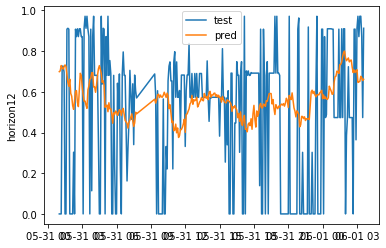

In [9]:
sns.lineplot(y_test.index[:300],y_test.iloc[:300], label="test")
sns.lineplot(y_test.index[:300],model.predict(X_test)[:300], label="pred")

file_path = file_path = '{}/Desktop/Portfolio_project/presentation/complete.png'.format(os.environ['HOME'])
plt.savefig(file_path)

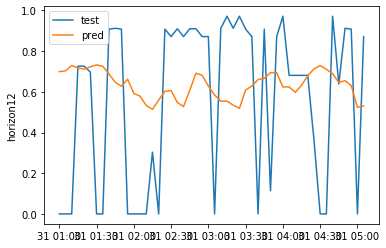

In [10]:
sns.lineplot(y_test.index[:50],y_test.iloc[:50], label="test")
sns.lineplot(y_test.index[:50],model.predict(X_test)[:50], label="pred")

file_path = file_path = '{}/Desktop/Portfolio_project/presentation/complete.png'.format(os.environ['HOME'])
plt.savefig(file_path)

### __horizon_24__

In [10]:
df = lag_horizon(df, 12, 24)

df.dropna(inplace=True)
print(df.index.min())
print(df.index.max())
print(df.shape)
df.head()

df.drop(columns="horizon12", inplace=True)

X_train, y_train, X_test, y_test = train_test_time_threshold(df,dt.datetime(2017,5,31,0,0,0),12,24)

print(df.columns)

print(X_train.index.max())
print(X_test.index.min())

model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)

errors(model,X_train, y_train, X_test, y_test)

2009-09-01 07:05:00
2019-08-01 00:55:00
(790439, 28)
Index(['CO2E_EMISSIONS_FACTOR', 'demand', 'demand_capacity', 'interconnector',
       'year', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
       'weekday_sin', 'month_sin', 'month_cos', 'year_sin', 'year_cos', 'lag1',
       'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10',
       'lag11', 'lag12', 'horizon24'],
      dtype='object')
2017-05-30 23:55:00
2017-05-31 01:00:00


/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:14:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.24265284131179332
test_MAE: 0.27109331920754526
train_sMAPE: 0.17385070000158154
test_sMAPE: 0.224704382978724


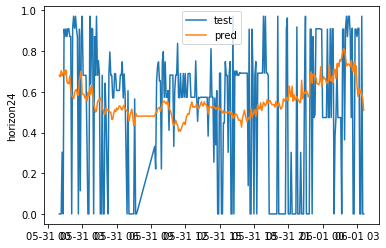

In [11]:
sns.lineplot(y_test.index[:300],y_test.iloc[:300], label="test")
sns.lineplot(y_test.index[:300],model.predict(X_test)[:300], label="pred")

file_path = file_path = '{}/Desktop/Portfolio_project/presentation/wo_interconnectors.png'.format(os.environ['HOME'])
plt.savefig(file_path)

### __horizon48__

In [12]:
df = lag_horizon(df, 12, 48)

df.dropna(inplace=True)
print(df.index.min())
print(df.index.max())
print(df.shape)
df.head()

df.drop(columns=["demand", "demand_capacity"], inplace=True)
df.columns
X_train, y_train, X_test, y_test = train_test_time_threshold(df,dt.datetime(2017,5,31,0,0,0),12,48)

df.drop(columns="horizon24", inplace=True)

print(df.columns)

print(X_train.index.max())
print(X_test.index.min())

model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)


errors(model,X_train, y_train, X_test, y_test)

2009-09-01 12:25:00
2019-07-31 18:50:00
(790330, 28)
Index(['CO2E_EMISSIONS_FACTOR', 'interconnector', 'year', 'minute_sin',
       'minute_cos', 'hour_sin', 'hour_cos', 'weekday_sin', 'month_sin',
       'month_cos', 'year_sin', 'year_cos', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
       'horizon48'],
      dtype='object')
2017-05-30 23:55:00
2017-05-31 01:00:00
[17:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_MAE: 0.2472440227234879
test_MAE: 0.2742494759377736
train_sMAPE: 0.177134106586857
test_sMAPE: 0.2266558246038854


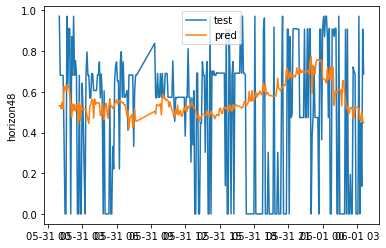

In [13]:
sns.lineplot(y_test.index[:300],y_test.iloc[:300], label="test")
sns.lineplot(y_test.index[:300],model.predict(X_test)[:300], label="pred")

file_path = file_path = '{}/Desktop/Portfolio_project/presentation/wo_interconnectors_demand.png'.format(os.environ['HOME'])
plt.savefig(file_path)

### __without lag1__

In [20]:
X_train, y_train, X_test, y_test = train_test_time_threshold(df,dt.datetime(2017,5,31,0,0,0),12,0)
X_train.drop(columns="lag1", inplace=True)
X_test.drop(columns="lag1", inplace=True)


print(X_train.index.max())
print(X_test.index.min())

model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)

rel_errors(model,X_train, y_train, X_test, y_test)
errors(model,X_train, y_train, X_test, y_test)

2017-05-30 23:55:00
2017-05-31 01:00:00
[17:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rel_train_mae: 0.29682926393319453
rel_test_mae: 0.4101835470535101
rel_train_mape: 29.682926393358308
rel_test_mape: 41.01835470539043


### __horizon12__

### __only lag1__

In [38]:
X_train, y_train, X_test, y_test = train_test_time_threshold(df,dt.datetime(2017,5,31,0,0,0),12,0)
X_train.drop(columns=["lag2","lag3","lag4","lag5","lag6","lag7","lag8","lag9","lag10","lag11","lag12"], inplace=True)
X_test.drop(columns=["lag2","lag3","lag4","lag5","lag6","lag7","lag8","lag9","lag10","lag11","lag12"], inplace=True)


print(X_train.index.max())
print(X_test.index.min())

model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)

rel_errors(model,X_train, y_train, X_test, y_test)
errors(model,X_train, y_train, X_test, y_test)

2017-05-30 23:55:00
2017-05-31 01:00:00


/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:53:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rel_train_mae: 0.290709847713657
rel_test_mae: 0.4098684186253851
rel_train_mape: 29.07098477140962
rel_test_mape: 40.98684186257749


In [39]:
X_train.head()

,demand,demand_capacity,interconnector,year,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,year_sin,year_cos,lag1
2009-09-01 01:05:00,1540.46,0.561122,204.99,2009,0.500000,8.660254e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861,0.871459
2009-09-01 01:10:00,1499.28,0.545420,171.40,2009,0.866025,5.000000e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861,0.980592
2009-09-01 01:15:00,1509.50,0.550675,181.68,2009,1.000000,2.832769e-16,0.258819,0.965926,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861,1.154818
2009-09-01 01:20:00,1504.69,0.548709,176.25,2009,0.866025,-5.000000e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861,0.976360
2009-09-01 01:25:00,1493.48,0.544586,166.35,2009,0.500000,-8.660254e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861,0.976360


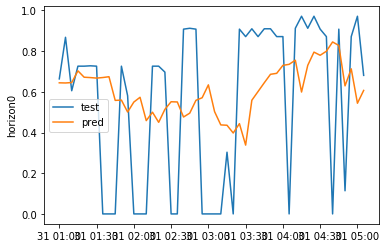

In [25]:
import seaborn as sns

sns.lineplot(y_test.index[:50],y_test.iloc[:50], label="test")
sns.lineplot(y_test.index[:50],model.predict(X_test)[:50], label="pred")